In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
import pqr

## Считываем данные

In [3]:
prices = pd.read_excel('factors/italy/price.xlsx', index_col=0, parse_dates=True)
index = pd.read_excel('factors/italy/benchmark.xlsx', index_col=0, parse_dates=True)['CLOSE']

pe = pd.read_excel('factors/italy/mults/pe.xlsx', index_col=0, parse_dates=True)
mcap = pd.read_excel('factors/italy/financials/market_cap.xlsx', index_col=0, parse_dates=True)
volume = pd.read_excel('factors/italy/liquidity/volume.xlsx', index_col=0, parse_dates=True)

## Создаем на основе данных факторы

In [4]:
# фильтр на основе среднедневного объема
liquidity_filter = pqr.Factor(volume).look_back().data > 2_000_000

# основной фактор на основе P/E
value = pqr.Factor(pe).look_back(3).hold(3)
value.filter(liquidity_filter)

# взвешивающий фактор на основе капитализации
size_w = pqr.Factor(mcap).look_back()

# бенчмарк уже готовый
benchmark = pqr.Benchmark('FTSE MIB').from_index(index)

## "Обучаем" факторную модель.

In [5]:
portfolios = pqr.fit_factor_model(
    stock_prices=prices,
    factor=value,
    weighting_factor=size_w,
    fee_rate=0.0005,
    balance=100_000,
    quantiles=3,
    add_wml=True,
    is_bigger_better=False
)

## После обучения у факторной модели появились портфели. С ними можно работать по отдельности

In [6]:
portfolios[0].returns

2016-04-30    0.000000
2016-05-31   -0.069791
2016-06-30   -0.205065
2016-07-31    0.147165
2016-08-31   -0.017629
                ...   
2020-12-31   -0.011313
2021-01-31   -0.036092
2021-02-28    0.160036
2021-03-31    0.110351
2021-04-30   -0.005231
Name: q(0.00, 0.33), Length: 61, dtype: float64

In [7]:
pqr.alpha(portfolios[0].returns, benchmark.returns)

/home/akbabkin/programming/notebooks/venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


-0.0021876977844496417

<AxesSubplot:>

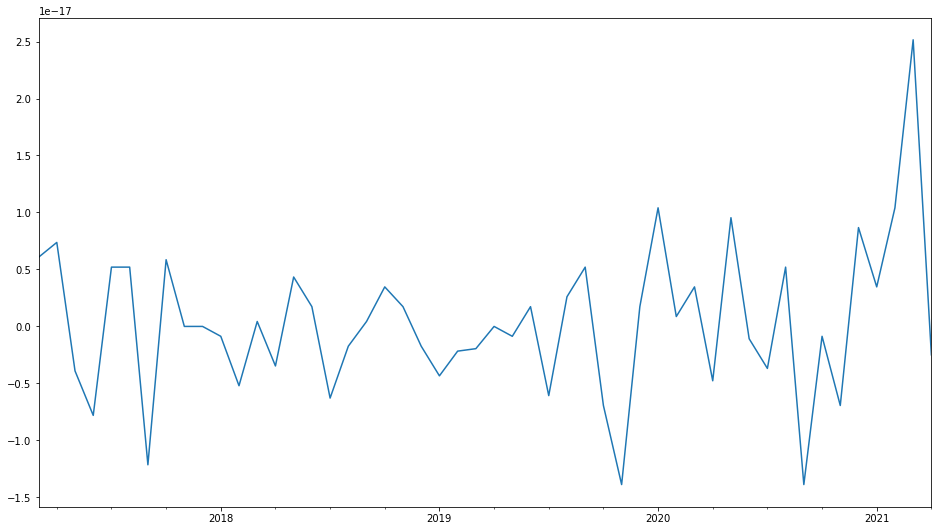

In [8]:
pqr.rolling_alpha(portfolios[0].returns, benchmark.returns).plot()

<AxesSubplot:>

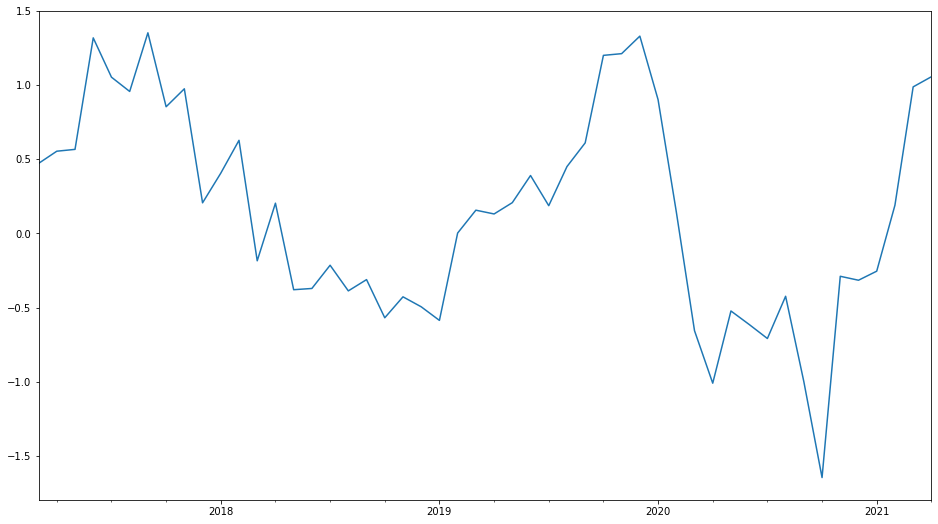

In [9]:
pqr.rolling_sharpe_ratio(portfolios[0].returns).plot()

In [10]:
pqr.max_drawdown(portfolios[0].returns)

-0.4433834203569407

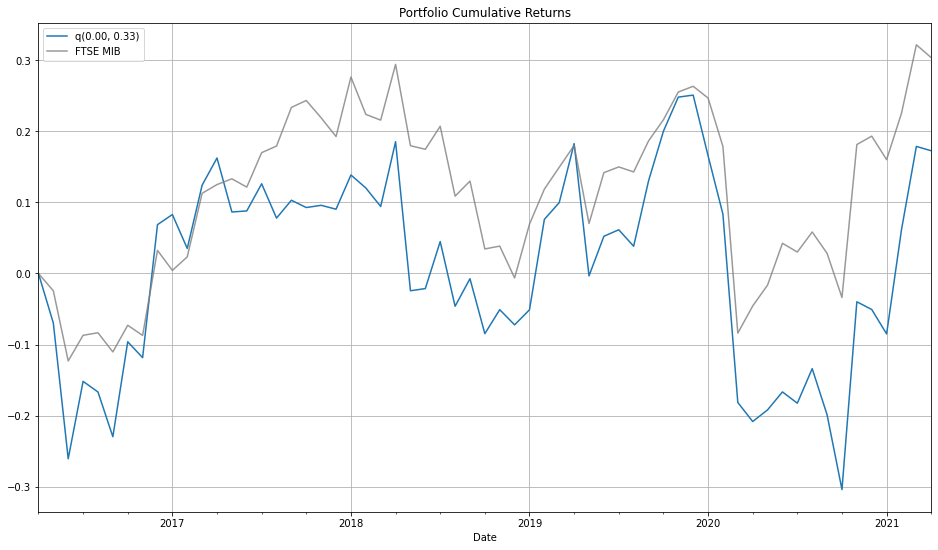

In [11]:
pqr.plot_cumulative_returns([portfolios[0]], benchmark)

## Сравниваем портфели 
tabulate пришлось убрать, поскольку при отрисовке больше 3 портфелей у меня слетало форматирование из-за того, что вывод не помещался. Пока временно сделал табличку с помощью пандаса

/home/akbabkin/programming/notebooks/venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/akbabkin/programming/notebooks/venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/akbabkin/programming/notebooks/venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/akbabkin/programming/notebooks/venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.co

,"q(0.00, 0.33)","q(0.33, 0.67)","q(0.67, 1.00)",wml
"Total Return, %",17.24,42.29,-1.40,-29.49
"Annual Return, %",3.18,7.18,-0.28,-6.64
"Annual Volatility, %",33.94,22.94,24.45,23.94
"Mean Return, %",0.72,0.79,0.22,-0.34
"Win Rate, %",52.46,60.66,50.82,40.98
"Volatility, %",9.80,6.62,7.06,6.91
"Maximum Drawdown, %",-44.34,-35.02,-27.85,-57.12
"VaR, %",-15.73,-10.22,-11.28,-10.24
"Expected Tail Loss, %",-19.59,-12.46,-14.25,-13.65
Rachev Ratio,1.18,1.16,1.07,1.05


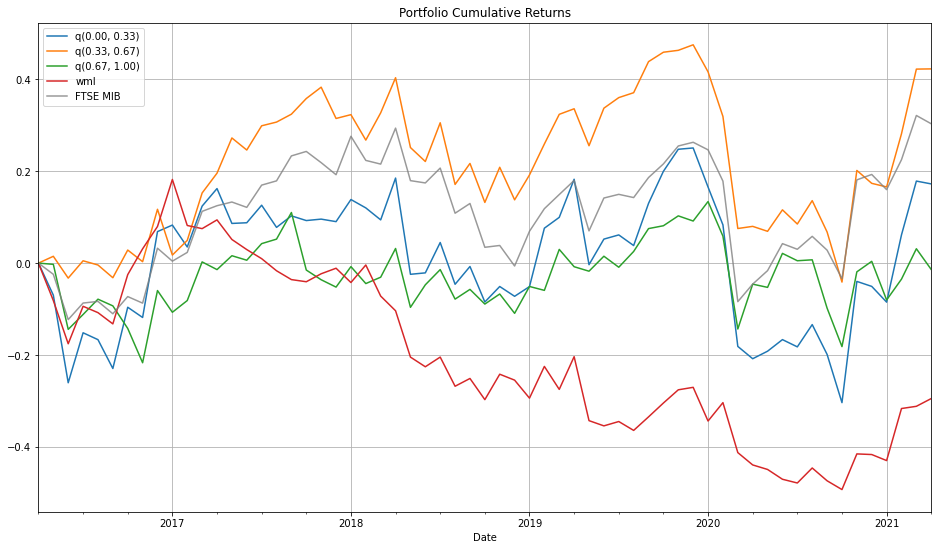

In [12]:
pqr.factor_model_tear_sheet(portfolios, benchmark)

## grid_search
Функция из модуля factor_model - принимает на вход сначала 3 списка/массива/чего угодно, по чему можно итерироваться; дальше все параметры повторяют параметры метода fit(). Возвращает словарь, в котором ключ - кортеж вида (1, 0, 1) - это, соответственно, looking_period, lag_period, holding_period, а значение - датафрейм с результатами (такой же, как и в compare_portfolios()). 

In [13]:
params = [
    (1, 0, 1),
    (3, 0, 3),
    (6, 0, 6),
    (12, 0, 12),
]

results = pqr.grid_search(prices, pe, params,
                          target_metric=pqr.sharpe_ratio,
                          mask=liquidity_filter, weighting_factor=size_w)

In [14]:
results

,"q(0.00, 0.33)","q(0.33, 0.67)","q(0.67, 1.00)"
"(1, 0, 1)",0.124277,0.512180,0.136792
"(3, 0, 3)",0.119259,0.426320,0.263807
"(6, 0, 6)",0.591688,0.298472,0.337107
"(12, 0, 12)",0.288728,0.453672,0.230247


<AxesSubplot:>

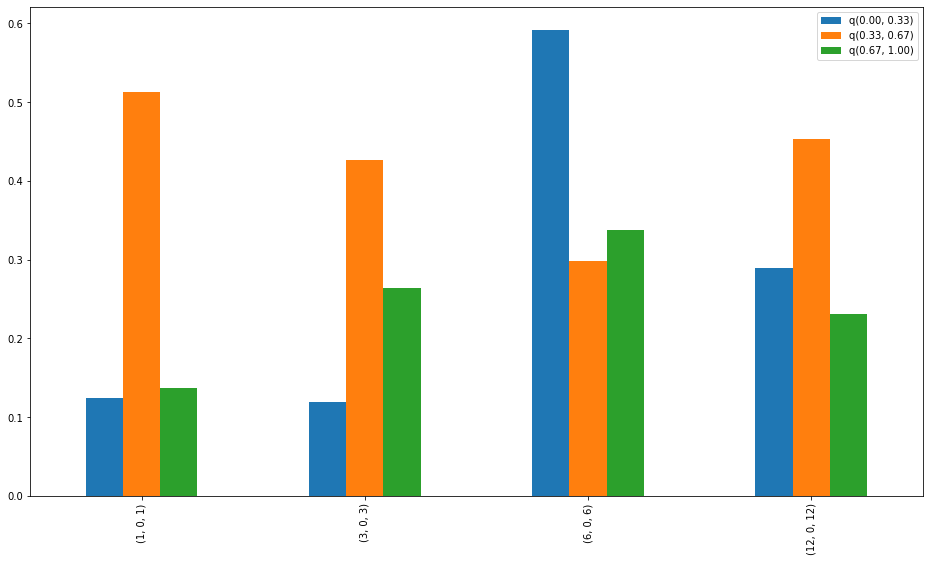

In [15]:
results.plot.bar()

# zero_intelligence_test

In [16]:
best_portfolio = portfolios[2]

In [17]:
%%time
%%capture

results = pqr.zero_intelligence_test(
    prices, 
    best_portfolio, 
    pqr.sharpe_ratio, 
    n=1000, 
    quantiles=5
)

CPU times: user 13.4 s, sys: 37.3 ms, total: 13.5 s
Wall time: 13.5 s


In [18]:
results

{0.04859068445110932: Portfolio('random'),
 0.6111702391839492: Portfolio('random'),
 0.8656747110778766: Portfolio('random'),
 0.9812553614681703: Portfolio('random'),
 1.3193565963728926: Portfolio('random')}

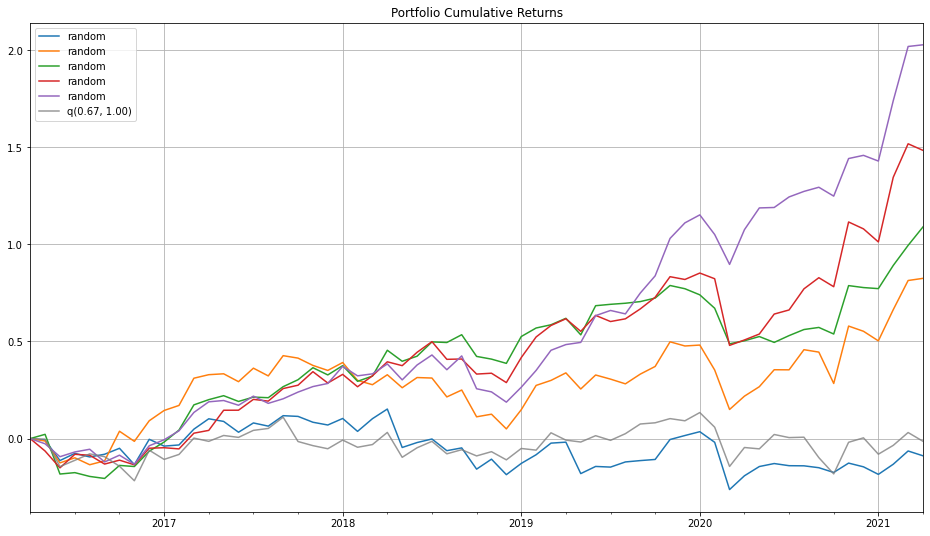

In [19]:
pqr.plot_cumulative_returns(results.values(), benchmark=best_portfolio)